In [1]:
import numpy as np
import pandas as pd
from numba import njit
import math
import matplotlib.pyplot as plt
import os
from aeon.utils.numba.general import z_normalise_series_2d
from aeon.distances import get_distance_function
import time

In [2]:
# %load_ext autoreload
# %autoreload 2
from ksfdtw.distance_measures import (
    psdtw_prime_vanilla as psdtw_prime_vanilla,
    psdtw_prime_lb_shen as psdtw_prime_lb_shen,
    cut_based_distance as cut_based_distance,
)
from ksfdtw.utils import precision_at_k

# Import Dataset

In [3]:
dataset_name = "GunPoint"
P = 3
l = 1.5
data = np.load(
    f"../data_processed/{dataset_name}_P{P}_uniform.npz",
    allow_pickle=True,
)
X_train_trans_uniform_concatenated = data["X_train_trans_uniform_concatenated"]

data = np.load(
    f"../data_processed/{dataset_name}_P{P}_l{l}_random.npz",
    allow_pickle=True,
)
X_train_trans_random_concatenated = data["X_train_trans_random_concatenated"]

## Z-normalise the transformed series

In [ ]:
X_train_trans_uniform_concatenated = z_normalise_series_2d(
    X_train_trans_uniform_concatenated
)
X_train_trans_random_concatenated = z_normalise_series_2d(
    X_train_trans_random_concatenated
)
instance_idx = 0

## Plot graph

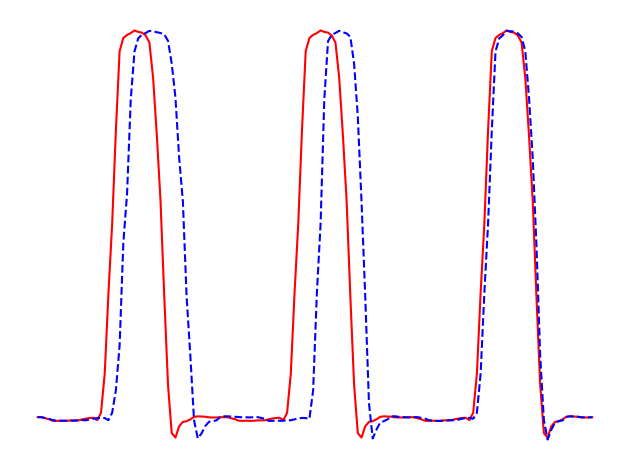

In [ ]:
plt.plot(X_train_trans_uniform_concatenated[instance_idx], color="red")
plt.plot(X_train_trans_random_concatenated[instance_idx], color="blue", linestyle="--")
plt.axis("off")
plt.tight_layout()
# plt.savefig("../figures/concatenation_uniform_vs_random.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Assign query and target sets

In [7]:
# Query set
query_set = X_train_trans_random_concatenated

# Target set
target_set = X_train_trans_uniform_concatenated
if len(query_set) != len(target_set):
    raise ValueError("query_set and target_set have different sizes!")

# Searching with distance measures provided in aeon

In [8]:
# *** Change here ***
# https://www.aeon-toolkit.org/en/latest/api_reference/distances.html
# https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.distances.get_distance_function.html

dist_func = lambda Q, C: get_distance_function("adtw")(Q, C, window=0.1)
# dist_func = lambda Q, C: get_distance_function("ddtw")(Q, C, window=0.1)
# dist_func = lambda Q, C: get_distance_function("dtw")(Q, C, window=0.1)
# dist_func = lambda Q, C: get_distance_function("erp")(Q, C, window=0.1)
# dist_func = lambda Q, C: get_distance_function("edr")(Q, C, window=0.1)
# dist_func = lambda Q, C: get_distance_function("lcss")(Q, C, window=0.1)
# dist_func = get_distance_function("manhattan")
# dist_func = get_distance_function("minkowski")
# dist_func = lambda Q, C: get_distance_function("msm")(Q, C, window=0.1)
# dist_func = get_distance_function("sbd")
# dist_func = lambda Q, C: get_distance_function("shape_dtw")(Q, C, window=0.1)
# dist_func = get_distance_function("squared")
# dist_func = lambda Q, C: get_distance_function("twe")(Q, C, window=0.1)
# dist_func = lambda Q, C: get_distance_function("wddtw")(Q, C, window=0.1)
# dist_func = lambda Q, C: get_distance_function("wdtw")(Q, C, window=0.1)

## Precision@k

Compute $P@k$ for querying $Q \in$ `query_set` using `method_name` on `target_set`

In [9]:
start = time.time()
precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
for i in range(0, len(query_set)):
    distances = np.array([dist_func(query_set[i], x) for x in target_set])

    precision_at_1 += precision_at_k(distances, i, 1)
    precision_at_3 += precision_at_k(distances, i, 3)
    precision_at_5 += precision_at_k(distances, i, 5)
    precision_at_7 += precision_at_k(distances, i, 7)
print(
    f"{precision_at_1 / len(query_set):.2f}",
    f"{precision_at_3 / len(query_set):.2f}",
    f"{precision_at_5 / len(query_set):.2f}",
    f"{precision_at_7 / len(query_set):.2f}",
)
end = time.time()
elapsed_time = end - start
print("Elapsed time for a single distance computation: " + str(elapsed_time))

0.60 0.78 0.84 0.88
Elapsed time for a single distance computation: 0.28331422805786133


# Searching with PSED, PSDTW

In [10]:
dist_method = 0  # 0 for PSED, 1 for PSDTW
vanilla = True  # True for vanilla, False for lb_shen
if vanilla:
    dist_func_p = lambda Q, C: psdtw_prime_vanilla(
        Q, C, l=l, P=P, r=0.1, dist_method=dist_method
    )
else:
    dist_func_p = lambda Q, C: psdtw_prime_lb_shen(
        Q, C, l=l, P=P, r=0.1, dist_method=dist_method
    )

## Warmup for numba

In [11]:
def dist_func(Q, C):
    dist, _, _ = dist_func_p(Q, C)
    return dist

In [12]:
dist_func(
    X_train_trans_uniform_concatenated[instance_idx],
    X_train_trans_random_concatenated[instance_idx],
)
start = time.time()
dist_func(
    X_train_trans_uniform_concatenated[instance_idx],
    X_train_trans_random_concatenated[instance_idx],
)
end = time.time()
elapsed_time = end - start
print("Elapsed time for a single distance computation: " + str(elapsed_time))

Elapsed time for a single distance computation: 0.0454556941986084


## Precision@k

In [13]:
all_distances = []
all_count_dist_calls = []
all_cuts = []
start = time.time()
precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
for i in range(0, len(query_set)):
    results = [dist_func_p(query_set[i], x) for x in target_set]
    dist_arr, count_dist_calls_arr, cuts_arr = zip(*results)
    distances = np.array(dist_arr)

    # store per-iteration results
    all_distances.append(distances)
    all_count_dist_calls.append(count_dist_calls_arr)
    all_cuts.append(cuts_arr)

    precision_at_1 += precision_at_k(distances, i, 1)
    precision_at_3 += precision_at_k(distances, i, 3)
    precision_at_5 += precision_at_k(distances, i, 5)
    precision_at_7 += precision_at_k(distances, i, 7)
print(
    f"{precision_at_1 / len(query_set):.2f},",
    f"{precision_at_3 / len(query_set):.2f},",
    f"{precision_at_5 / len(query_set):.2f},",
    f"{precision_at_7 / len(query_set):.2f}",
)
end = time.time()
elapsed_time = end - start
print("Elapsed time: " + str(elapsed_time))

0.96, 1.00, 1.00, 1.00
Elapsed time: 149.5251500606537


In [14]:
os.makedirs("../outputs", exist_ok=True)
np.savez(
    f"../outputs/{dataset_name}_P{P}_l{l}_dist_method{dist_method}_vanilla{vanilla}.npz",
    all_distances=np.array(all_distances, dtype=object),
    all_count_dist_calls=np.array(all_count_dist_calls, dtype=object),
    all_cuts=np.array(all_cuts, dtype=object),
    precision_at_1=precision_at_1 / len(query_set),
    precision_at_3=precision_at_3 / len(query_set),
    precision_at_5=precision_at_5 / len(query_set),
    precision_at_7=precision_at_7 / len(query_set),
    elapsed_time=elapsed_time,
)

# Searching with Cut-based distance

## Import computed cuts

In [15]:
data = np.load(
    f"../outputs/{dataset_name}_P{P}_l{l}_dist_method{dist_method}_vanilla{vanilla}.npz",
    allow_pickle=True,
)

all_distances = np.ascontiguousarray(data["all_distances"], dtype=np.float64)
all_count_dist_calls = np.ascontiguousarray(
    data["all_count_dist_calls"], dtype=np.float64
)
all_cuts = np.ascontiguousarray(data["all_cuts"], dtype=np.float64)

In [16]:
print("precision@1 =", data["precision_at_1"])
print("precision@3 =", data["precision_at_3"])
print("precision@5 =", data["precision_at_5"])
print("precision@7 =", data["precision_at_7"])
print("elapsed time =", data["elapsed_time"])

precision@1 = 0.96
precision@3 = 1.0
precision@5 = 1.0
precision@7 = 1.0
elapsed time = 149.5251500606537


## Check total count_dist_calls

In [17]:
total_count_dist_calls = 0
for r in all_count_dist_calls:
    total_count_dist_calls += np.sum(r)
print(total_count_dist_calls)

659109745.0


## Compute Cut-based distances

In [18]:
dist_method = 8

In [19]:
precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
for i in range(0, len(query_set)):
    distances = np.array(
        [
            cut_based_distance(
                query_set[i],
                target_set[j],
                2,
                3,
                0.1,
                dist_method=dist_method,
                cuts=all_cuts[i][j],
            )
            for j in range(0, len(target_set))
        ]
    )
    precision_at_1 += precision_at_k(distances, i, 1)
    precision_at_3 += precision_at_k(distances, i, 3)
    precision_at_5 += precision_at_k(distances, i, 5)
    precision_at_7 += precision_at_k(distances, i, 7)
print(
    f"{precision_at_1 / len(query_set):.2f},",
    f"{precision_at_3 / len(query_set):.2f},",
    f"{precision_at_5 / len(query_set):.2f},",
    f"{precision_at_7 / len(query_set):.2f}",
)

1.00, 1.00, 1.00, 1.00


In [19]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")
###
###
###

This notebook was last run end-to-end on: 2025-11-08 16:12:17.127252

